# Controlling a Hanging Plotter-Bot ('V-Plotter')

Code for processing SVGs into G-Code and sending that over serial to a 3D printer board to move a pen around and draw things.

In [1]:
import xml.etree.ElementTree as ET
from io import StringIO
from IPython.display import Markdown

## Loading SVGs with lines or polylines

Defining `svg_to_moves`

A good source for these is the [PINTR](https://javier.xyz/pintr) tool ([codebase](https://github.com/javierbyte/pintr)). Tick 'single-line' to get a single polyline, or uncheck for one with a bunch of straight lines.

We want to load SVGs with lines or polylines and turn them into 'Go to X, Y', 'Pen Down', 'Go to 'X2, Y2'... style instructions. Only problems:
- Scaling issues
- We want to control a hanging printer which has different kinematics. Moving the 'X' axis actually shortens one line, which moves at a sort of diagonal.
- Long stright lines will be curved unless we break them up

So, this notebook shows how to:
- Load an SVG and break out line segments + pen up/down
- Cut up long lines
- Convert to G-Code for a hanging plotter
- Visualize the result to make sure they make sense

In [2]:
# A triangle
svg1 = """<svg width="200" height="200" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
  <polyline points="10,90 50,10 90,90 10,90" stroke="black" stroke-width="2" fill="none"/>
</svg>"""

# A square with multiple lines
svg2 = """<svg width="200" height="200" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
  <line x1="10" y1="10" x2="90" y2="10" stroke="black" stroke-width="2"/>
  <line x1="90" y1="10" x2="90" y2="90" stroke="black" stroke-width="2"/>
  <line x1="90" y1="90" x2="10" y2="90" stroke="black" stroke-width="2"/>
  <line x1="10" y1="90" x2="10" y2="10" stroke="black" stroke-width="2"/>
</svg>"""

In [3]:
Markdown(f"Triangle:{svg1}Square:{svg2}")

Triangle:<svg width="200" height="200" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
  <polyline points="10,90 50,10 90,90 10,90" stroke="black" stroke-width="2" fill="none"/>
</svg>Square:<svg width="200" height="200" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
  <line x1="10" y1="10" x2="90" y2="10" stroke="black" stroke-width="2"/>
  <line x1="90" y1="10" x2="90" y2="90" stroke="black" stroke-width="2"/>
  <line x1="90" y1="90" x2="10" y2="90" stroke="black" stroke-width="2"/>
  <line x1="10" y1="90" x2="10" y2="10" stroke="black" stroke-width="2"/>
</svg>

**Prompt: Create a parser that takes in an SVG and returns a list of strings. For motion, use `G1 X183.157 Y154.610` (with the X and Y locations). Otherwise use `PENUP` and `PENDOWN`. It will always start with penup then a move to the start of the first line/polyline in the SVG. Call the function svg_to_moves**

In [4]:
def svg_to_moves(svg_str):
    root = ET.parse(StringIO(svg_str)).getroot()
    moves, current_pos = [], None
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    
    def add_move(x, y, new_path=False):
        nonlocal current_pos, moves
        if current_pos == (x, y): return
        if new_path: moves += ['PENUP', f'G0 X{x:.3f} Y{y:.3f}', 'PENDOWN']
        else: moves.append(f'G1 X{x:.3f} Y{y:.3f}')
        current_pos = (x, y)
    
    for elem in root.findall('.//line', ns) or root.findall('.//svg:line', ns) or root.findall('.//line'):
        add_move(float(elem.get('x1')), float(elem.get('y1')), new_path=True)
        add_move(float(elem.get('x2')), float(elem.get('y2')))
    
    for elem in root.findall('.//polyline', ns) or root.findall('.//svg:polyline', ns) or root.findall('.//polyline'):
        points = elem.get('points').strip().split()
        coords = [(float(p.split(',')[0]), float(p.split(',')[1])) for p in points]
        if not coords: continue 
        add_move(*coords[0], new_path=True)
        for x, y in coords[1:]: add_move(x, y)
            
    return moves + ['PENUP']

# Test with both SVGs
print("Triangle:")
print('\n'.join(svg_to_moves(svg1)))
print("\nSquare:")
print('\n'.join(svg_to_moves(svg2)))

Triangle:
PENUP
G0 X10.000 Y90.000
PENDOWN
G1 X50.000 Y10.000
G1 X90.000 Y90.000
G1 X10.000 Y90.000
PENUP

Square:
PENUP
G0 X10.000 Y10.000
PENDOWN
G1 X90.000 Y10.000
G1 X90.000 Y90.000
G1 X10.000 Y90.000
G1 X10.000 Y10.000
PENUP


## Transforming

It's nice to be able to shift and scale. `transform_moves`

**Prompt: Write a 'transform_moves' function that scales the coords by `scale_x` and `scale_y` and shifts them by `offset_x` and `offset_y`.**

In [6]:
def transform_moves(moves, scale_x=1.0, scale_y=1.0, offset_x=0.0, offset_y=0.0):
    result = []
    for move in moves:
        if move in ('PENUP', 'PENDOWN'): result.append(move)
        else:
            # Parse X and Y from G1 command
            parts = move.split()
            x = float(parts[1][1:]) * scale_x + offset_x  
            y = float(parts[2][1:]) * scale_y + offset_y
            result.append(f'{parts[0]} X{x:.3f} Y{y:.3f}')
    return result

moves = svg_to_moves(svg1)
moves = transform_moves(moves, 0.5, 0.5, -50, 0)
print('\n'.join(moves))

PENUP
G0 X-45.000 Y45.000
PENDOWN
G1 X-25.000 Y5.000
G1 X-5.000 Y45.000
G1 X-45.000 Y45.000
PENUP


## Breaking Up Long Moves

A long line in XY will turn into a curve in the plotter, we can break it up into shorter segments. `break_lines(moves, max_length)`

**Prompt: Write a function `break_lines(moves, max_length)` that specifies a max line length and trims any longer lines into smaller segments < max_length (a line should end up in segments of equal length). It only needs to apply this when the pen is down (i.e. G1 moves not G0).**

In [8]:
def break_lines(moves, max_length):
    result = []
    def distance(x1, y1, x2, y2): return ((x2-x1)**2 + (y2-y1)**2)**0.5
    def interpolate(x1, y1, x2, y2, frac): return x1 + (x2-x1)*frac, y1 + (y2-y1)*frac
    last_x = last_y = None
    for move in moves:
        if 'PEN' in move: result.append(move)
        else:
            parts = move.split()
            x = float(parts[1][1:])
            y = float(parts[2][1:])
            
            if parts[0] == 'G0': result.append(move)
            else:
                dist = distance(last_x, last_y, x, y)
                if dist <= max_length: result.append(move)
                else:
                    n_segments = int(dist / max_length) + 1
                    for i in range(1, n_segments + 1):
                        frac = i / n_segments
                        new_x, new_y = interpolate(last_x, last_y, x, y, frac)
                        result.append(f'G1 X{new_x:.3f} Y{new_y:.3f}')
            
            last_x, last_y = x, y
            
    return result

# Test with a long horizontal line
moves = svg_to_moves('''<svg width="200" height="200" viewBox="0 0 100 100">
<line x1="10" y1="50" x2="90" y2="50" stroke="black"/></svg>''')
print("Original moves:\n"+'\n'.join(moves))
print("\nBroken into segments of max length 20:\n"+'\n'.join(break_lines(moves, 20)))

Original moves:
PENUP
G0 X10.000 Y50.000
PENDOWN
G1 X90.000 Y50.000
PENUP

Broken into segments of max length 20:
PENUP
G0 X10.000 Y50.000
PENDOWN
G1 X26.000 Y50.000
G1 X42.000 Y50.000
G1 X58.000 Y50.000
G1 X74.000 Y50.000
G1 X90.000 Y50.000
PENUP


## Converting to V-Plotter

We have XY coords, we want instead modifications to lengths of string... `c_to_v`

A hanging plotter has two motors, `motor_sep` mm apart. They have pulleys on, and are driven by a board that expects them to move in a cartesian (X-Y) 3D printer. Around the pulleys are strings, starting at length `string_length` mm. Sending a command `G1 X10.000 Y90.000` won't move the pen (hanging at the bottom intersection of both strings) to (10, 90) in XY space, it will instead let out 10mm of string on the left motor and 90 on the right! So, we need to define the kinematics (given an initial cartesian command, where will the pen end up) and the inverse kinematics (given a desired point like (10, 90) what should we send to move the pen to that point).

### Simulating A Plotter (forward kinematics)

**Prompt: For debugging, I want a simulation of the hanging arrangement. Given motor sep and string length at (0, 0), I want it to draw ouw what would happen being sent a bunch of moves. Please implement this - then we'll move on to the IK and use the sim to check. Use matplotlib for visuals.**

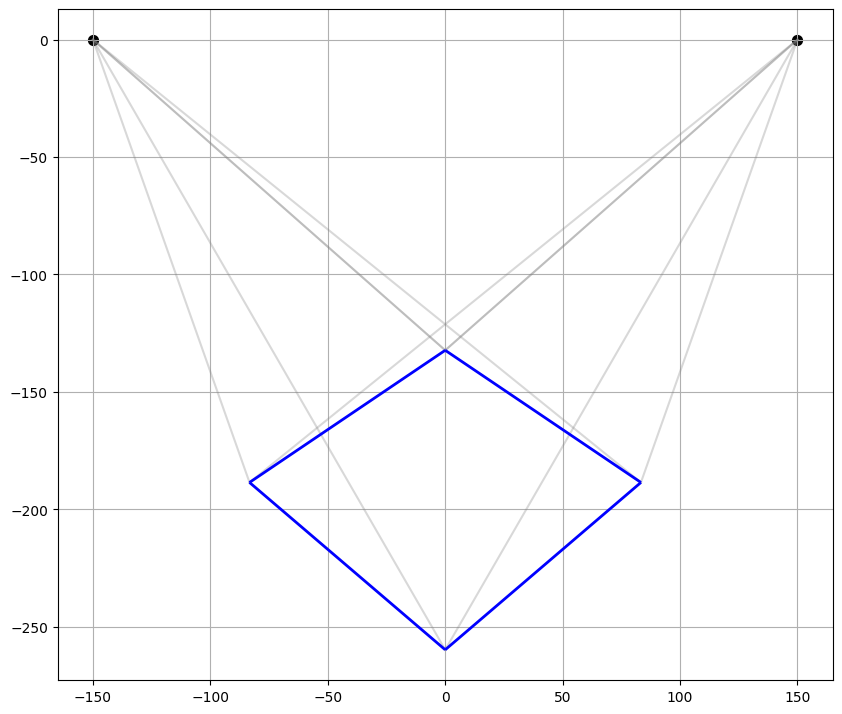

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def simulate_vplotter(moves, motor_sep=300, string_length=200):
    """Simulate what happens when we send moves to a v-plotter"""
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    
    # Plot motors
    motors = np.array([[-motor_sep/2,0], [motor_sep/2,0]])
    ax.scatter(motors[:,0], motors[:,1], c='black', s=50)
    
    points = []
    pen_down = False
    for move in moves:
        if move == 'PENUP': pen_down = False
        elif move == 'PENDOWN': pen_down = True
        else:
            parts = move.split()
            l1 = float(parts[1][1:])
            l2 = float(parts[2][1:])
            points.append((l1, l2, pen_down))
    
    segments = []
    last_pt = None
    for l1,l2,pen in points:
        sl1 = string_length + l1
        sl2 = string_length + l2
        
        d = motor_sep
        r1,r2 = sl1,sl2
        
        x = (d*d - r2*r2 + r1*r1)/(2*d)
        # Take negative y for lower intersection
        y = -np.sqrt(r1*r1 - x*x)
        
        x = x - motor_sep/2
        
        if last_pt is not None and pen:
            segments.append([last_pt, [x,y]])
        last_pt = [x,y]
        
        ax.plot([-motor_sep/2,x], [0,y], 'gray', alpha=0.3)
        ax.plot([motor_sep/2,x], [0,y], 'gray', alpha=0.3)
    
    lc = LineCollection(segments, colors='blue', linewidth=2)
    ax.add_collection(lc)
    
    ax.grid(True)
    return fig

test_moves = [
    'PENUP',
    'G0 X0 Y0',
    'PENDOWN',
    'G1 X100 Y0',
    'G1 X100 Y100',
    'G1 X0 Y100',
    'G1 X0 Y0',
    'PENUP'
]

fig = simulate_vplotter(test_moves)
plt.show()

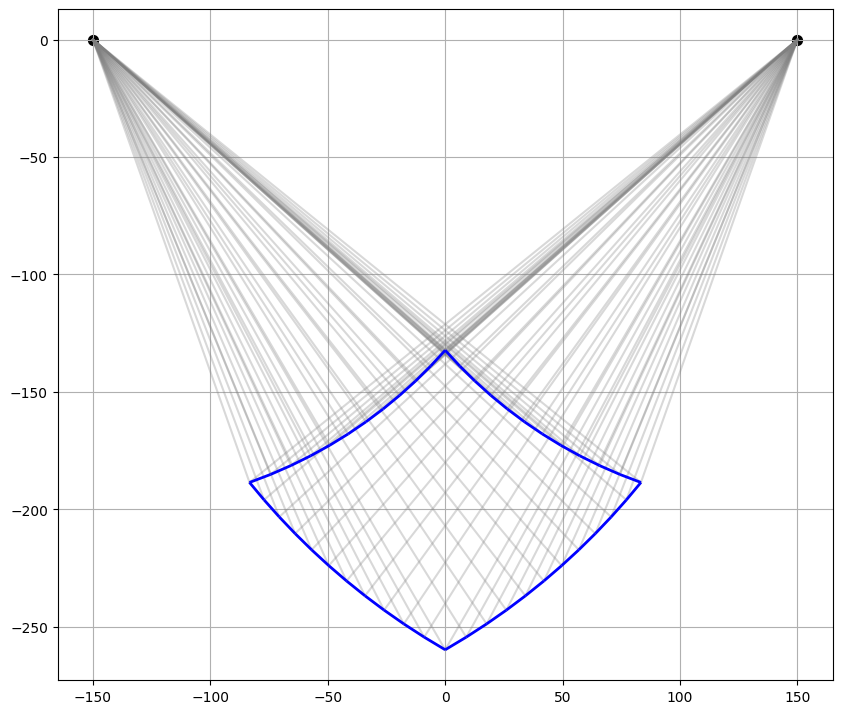

In [11]:
# And actually they'll be curved - if we draw some intermediate points you can see this:
fig = simulate_vplotter(break_lines(test_moves, 10))
plt.show()

### Inverse Kinematics

**Prompt: Please write function `c_t_v` that takes the plotter params and a set of moves defined in cartesian space, and converts them such that they'll work on the plotter. Test it with the square from before.**

V-plotter moves:
PENUP
G0 X5.913 Y69.072
PENDOWN
G1 X69.072 Y5.913
G1 X38.537 Y-35.988
G1 X-35.988 Y38.537
G1 X5.913 Y69.072
PENUP


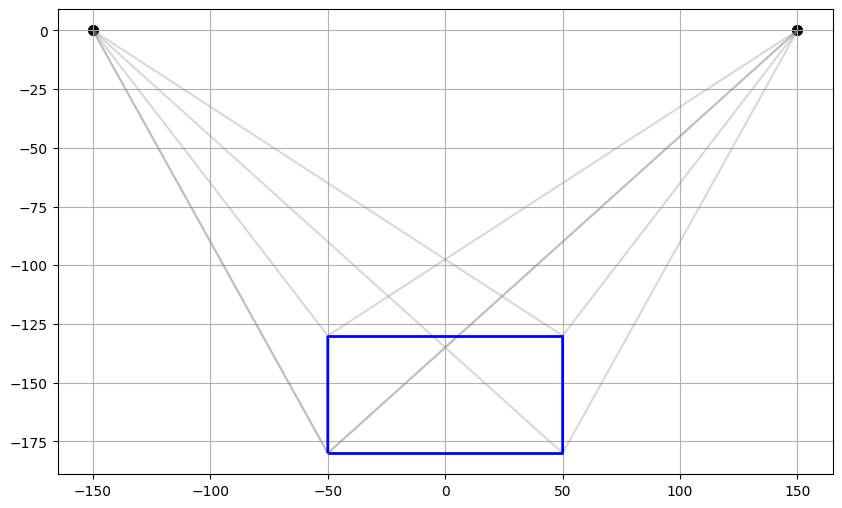

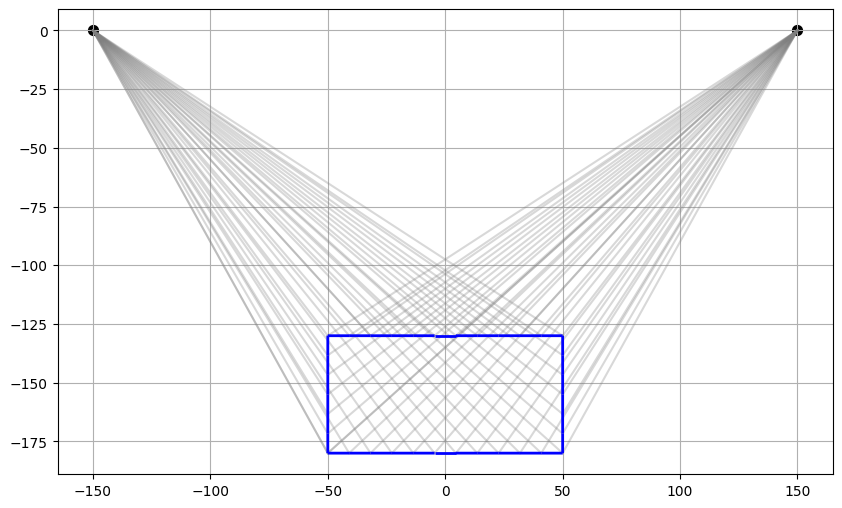

In [16]:
def c_to_v(moves, motor_sep=300, string_length=200):
    """Convert cartesian moves to v-plotter moves"""
    result = []
    
    def get_string_lengths(x, y):
        # Move x to be relative to left motor
        x = x + motor_sep/2
        # Get distances to each motor
        l1 = np.sqrt(x**2 + y**2) - string_length
        l2 = np.sqrt((motor_sep-x)**2 + y**2) - string_length
        return l1, l2
    
    for move in moves:
        if 'PEN' in move: result.append(move)
        else:
            parts = move.split()
            x = float(parts[1][1:])
            y = float(parts[2][1:])
            l1, l2 = get_string_lengths(x, y)
            result.append(f'{parts[0]} X{l1:.3f} Y{l2:.3f}')
    
    return result

# Test with square
cart_square = [
    'PENUP',
    'G0 X-50 Y-180',
    'PENDOWN',
    'G1 X50 Y-180',
    'G1 X50 Y-130',
    'G1 X-50 Y-130',
    'G1 X-50 Y-180',
    'PENUP'
]

# Convert to v-plotter moves
v_moves = c_to_v(cart_square)
print("V-plotter moves:")
print('\n'.join(v_moves))

# Simulate to verify
fig = simulate_vplotter(v_moves)
plt.show()

# Show with subdivided lines
v_moves_sub = c_to_v(break_lines(cart_square, 10))
fig = simulate_vplotter(v_moves_sub)
plt.show()

In [17]:
c_to_v(cart_square)

['PENUP',
 'G0 X5.913 Y69.072',
 'PENDOWN',
 'G1 X69.072 Y5.913',
 'G1 X38.537 Y-35.988',
 'G1 X-35.988 Y38.537',
 'G1 X5.913 Y69.072',
 'PENUP']

## Preparing a Drawing

In [18]:
# import glob
# glob.glob('/mnt/c/Users/Johno/Downloads/*.svg')

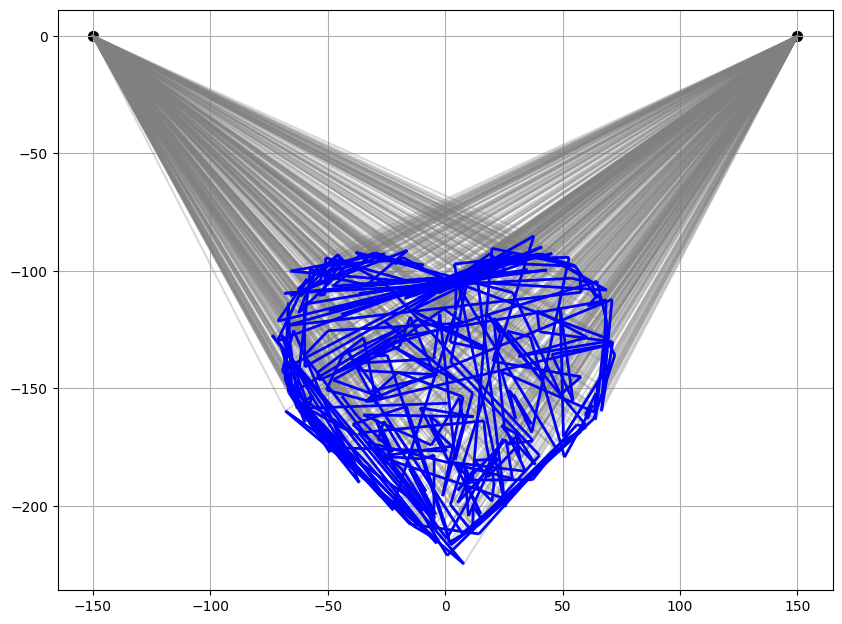

In [19]:
with open('/mnt/c/Users/Johno/Downloads/PINTR (4).svg') as f:
    svg = f.read()
moves = svg_to_moves(svg)
moves = transform_moves(moves, 0.15, 0.15, -80, 80) # NB: y_offset moves it *down*
# moves = break_lines(moves, 30)
moves = c_to_v(moves)
fig = simulate_vplotter(moves)
plt.show()

## Sending GCode

In [22]:
import serial, time
from tqdm.auto import tqdm

In [ ]:
ser = serial.Serial('/dev/ttyACM0', 115200, timeout=1)

In [ ]:
def send_gcode(command, ser, wait=0.2):
    """Send a single G-code command to the Duet and return the response."""
    cmd_str = command.strip() + '\n'
    ser.write(cmd_str.encode('ascii'))
    time.sleep(wait)  # Wait a bit for the Duet to process and respond
    response = ""
    while True:
        chunk = ser.read(1000).decode('ascii', errors='ignore')
        if not chunk: break
        response += chunk
    return response

In [20]:
moves[:5]

['PENUP',
 'G0 X17.362 Y15.978',
 'PENDOWN',
 'G1 X-17.576 Y62.752',
 'G1 X38.918 Y65.220']

In [24]:
for move in tqdm(moves):
    if 'PEN' in move:
        print(move)
        time.sleep(1) # Act fast ;)
    else:
        pass # send_gcode(move, ser)

  0%|          | 0/364 [00:00<?, ?it/s]

PENUP
PENDOWN
PENUP


Useful GCode:

```python
# Set 0 position
for axis in ['X', 'Y', 'Z']:
    print(send_gcode(f"G92 {axis}0", ser))

# Try to set new bounds
send_gcode('M208 X-2000 Y-2000', ser)
send_gcode('M208 X2000 Y2000', ser)
send_gcode('M208', ser) # Prints out bounds)

# Disable steppers to manually move them:
disable_response = send_gcode("M18", ser)
print("Disable steppers response:", disable_response)
```